## Proyect-Kaggle-Competition 💎

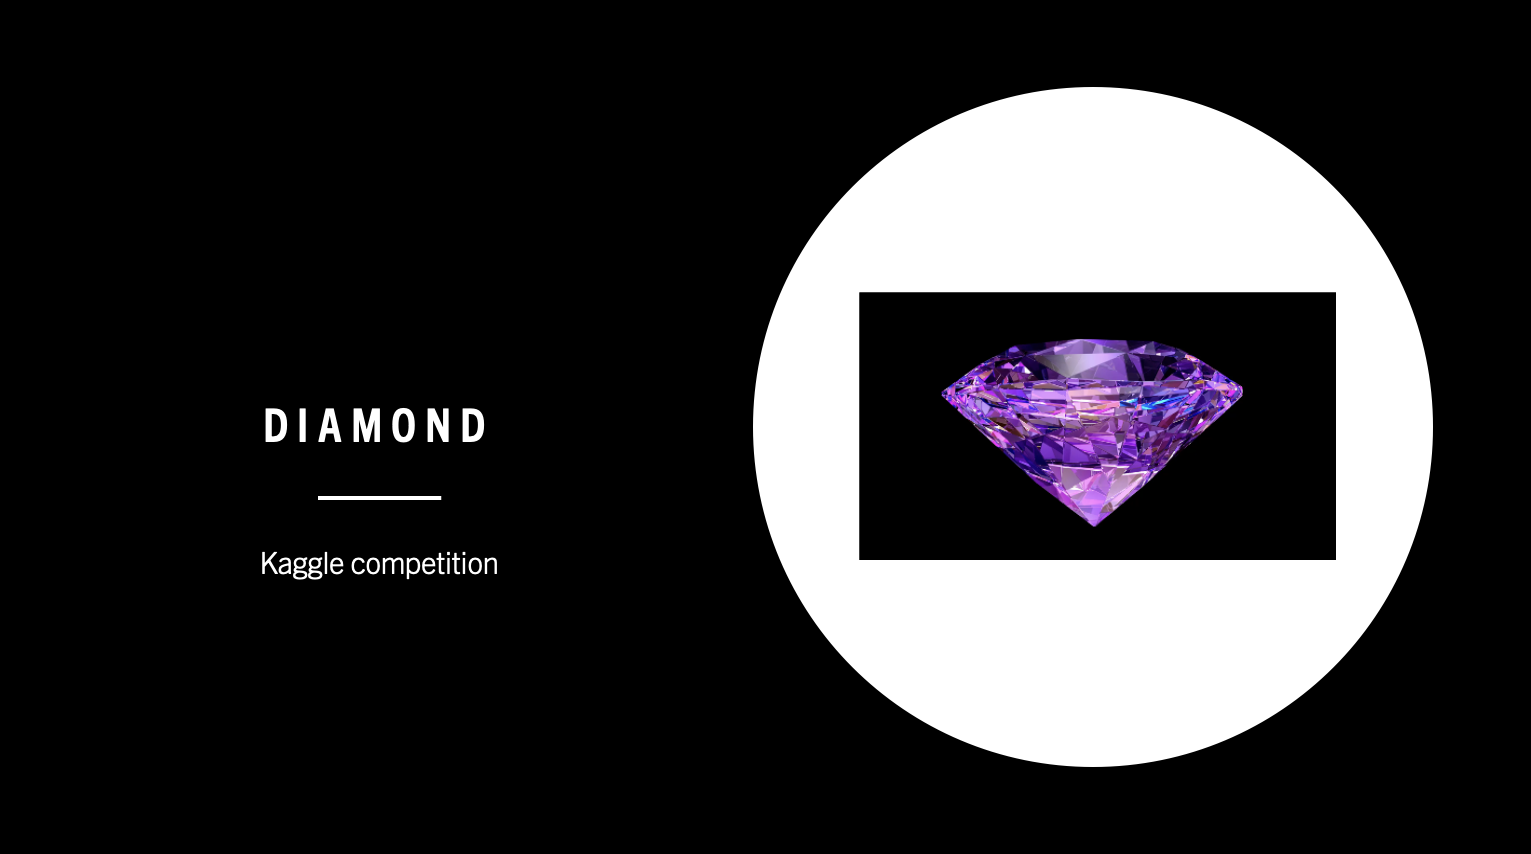

`d`: only for test & sample submission files, id for prediction sample identification

`price`: price in USD

`carat`: weight of the diamond

`cut`: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

`color`: diamond colour

`clarity`: a measurement of how clear the diamond is

`x`: length in mm

`y`: width in mm

`z`: depth in mm

`depth`: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

`table`: width of top of diamond relative to widest point (43--95)

### Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

#Plot
import matplotlib.pyplot as plt

#Statsmodels
import statsmodels.formula.api as smf

#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error

#ModelSelection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

#Linear
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor

#Ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Neighbors
from sklearn.neighbors import KNeighborsRegressor

#Hyperopt
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#CrossValidation
from sklearn.model_selection import cross_val_score

#XGBOOST
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### Download the dataset

In [2]:
!kaggle competitions download -c diamonds-datamad0321

diamonds-datamad0321.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!tar -xzvf diamonds-datamad0321.zip

x sample_submission.csv
x test.csv
x train.csv


In [4]:
!rm -rf pfizer-vaccine-tweets.zip

In [5]:
!ls

Kaggle_competition-Copy1.ipynb model_1.csv
Kaggle_competition.ipynb       sample_submission.csv
README.md                      test.csv
diamonds-datamad0321.zip       train.csv
model.csv


### 0. Explore the dataset

In [2]:
df_test = pd.read_csv('data/test.csv',encoding = "ISO-8859-1")
df_train = pd.read_csv('data/train.csv',encoding = "ISO-8859-1")

In [3]:
df_test.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [4]:
df_train.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40455 non-null  int64  
 1   carat    40455 non-null  float64
 2   cut      40455 non-null  object 
 3   color    40455 non-null  object 
 4   clarity  40455 non-null  object 
 5   depth    40455 non-null  float64
 6   table    40455 non-null  float64
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
 10  price    40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13485 entries, 0 to 13484
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13485 non-null  int64  
 1   carat    13485 non-null  float64
 2   cut      13485 non-null  object 
 3   color    13485 non-null  object 
 4   clarity  13485 non-null  object 
 5   depth    13485 non-null  float64
 6   table    13485 non-null  float64
 7   x        13485 non-null  float64
 8   y        13485 non-null  float64
 9   z        13485 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.0+ MB


### Price variable

In [7]:
df_train.price.describe()

count    40455.000000
mean         7.785853
std          1.016600
min          5.787000
25%          6.851000
50%          7.785000
75%          8.581500
max          9.843000
Name: price, dtype: float64

In [58]:
df_train["price"].mean()

7.785853170189099

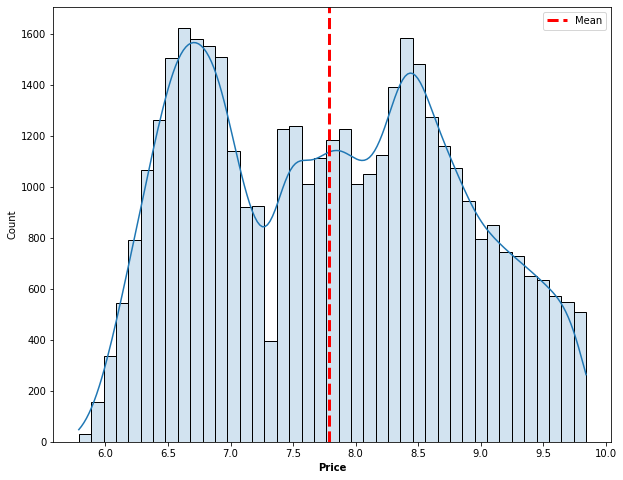

In [59]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x="price", kde=True, alpha = 0.2)

plt.axvline(x = df_train["price"].mean(), c ="red", linewidth = 3, linestyle = "--", label = "Mean")

plt.xlabel("Price", fontweight = "bold")

plt.legend()
plt.savefig("Target.jpg", dpi = 100)
plt.show();

### 1. Correlation between variables

In [9]:
corrMatrix=df_train[['carat','depth','table','x','y','z','price']].corr()

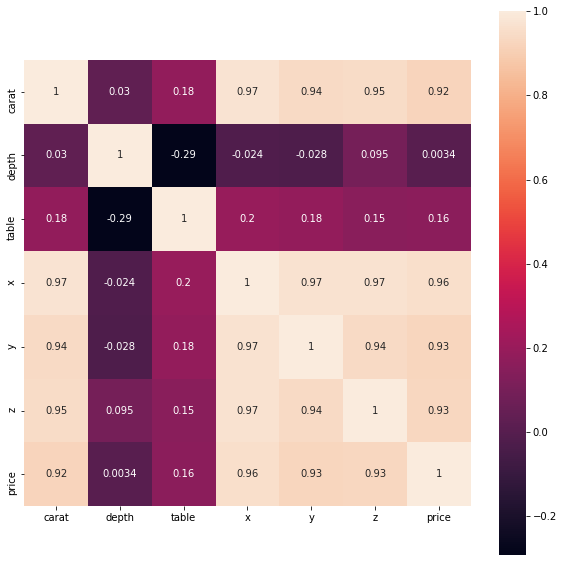

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corrMatrix, square=True,annot=True)

In [11]:
corrMatrix=df_test[['carat','depth','table','x','y','z']].corr()

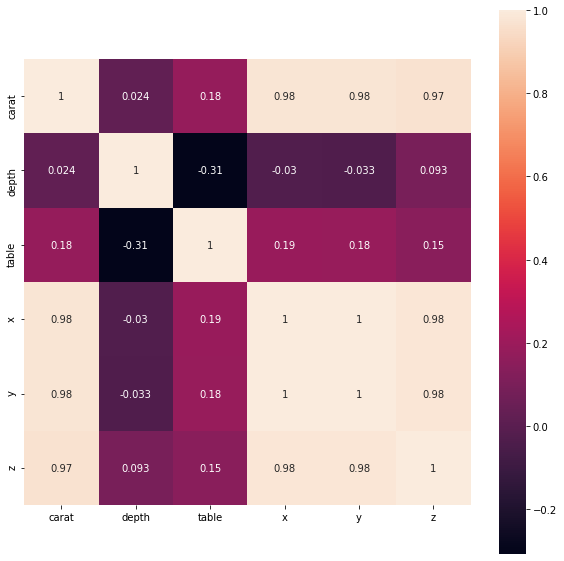

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corrMatrix, square=True,annot=True)

In [13]:
results = smf.ols("price ~ carat + depth + table + x + y + z", data = df_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 8.116e+04
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        18:20:03   Log-Likelihood:                -6125.0
No. Observations:               40455   AIC:                         1.226e+04
Df Residuals:                   40448   BIC:                         1.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9189      0.095      9.623      0.000       0.732       1.106
carat         -0.6642      0.014    -48.967      0.000      -0.691      -0.638
depth          0.0230      0.001     19.754      0.000       0.021       0.025
table         -0.0101      0.001    -15.105      0.000      -0.011      -0.009
x              1.0791      0.009    123.984      0.000       1.062       1.096
y              0.0362      0.005      7.499      0.000       0.027       0.046
z              0.0469      0.009      5.385      0.000       0.030       0.064
==============================================================================
Omnibus:                    39148.053   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21477594.704
Skew:                           3.875   Prob(JB):                         0.00
Kurtosis:                     115.612   Cond. No.                     5.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The model explains 92% of the variable in price
- Coef is the measurement of how change in that variable affects the price (in this case, x have a positive coef and the change is greater than the others)

### 2. Handle Remaining Categorical Data & Convert to Ordinal

#### 2.1 CUT

In [14]:
df_test.cut.unique()

array(['Ideal', 'Good', 'Premium', 'Very Good', 'Fair'], dtype=object)

In [15]:
df_test['cut'] = df_test['cut'].replace(['Premium'],'Ideal')

In [16]:
df_train.cut.unique()

array(['Premium', 'Good', 'Very Good', 'Ideal', 'Fair'], dtype=object)

In [17]:
df_train['cut'] = df_train['cut'].replace(['Premium'],'Ideal')

In [18]:
dic_for_cut = { "Fair": 1,
                "Good": 2,
                "Very Good": 3,
                "Ideal":4,
}

In [19]:
df_test.cut = df_test.cut.map(dic_for_cut)

In [20]:
df_train.cut = df_train.cut.map(dic_for_cut)

#### 2.2 Color

In [21]:
df_test.color.unique()

array(['H', 'D', 'F', 'E', 'G', 'I', 'J'], dtype=object)

In [22]:
df_train.color.unique()

array(['G', 'H', 'J', 'F', 'E', 'I', 'D'], dtype=object)

In [23]:
dic_for_color = { "D": 7,
                "E": 6,
                "F": 5,
                "G":4,
                "H": 3,
                "I": 2,
                "J":1,
}

In [24]:
df_test.color = df_test.color.map(dic_for_color)

In [25]:
df_train.color = df_train.color.map(dic_for_color)

#### 2.3 Clarity

In [26]:
df_train.clarity.unique()

array(['VS1', 'VS2', 'SI2', 'IF', 'SI1', 'VVS2', 'VVS1', 'I1'],
      dtype=object)

In [27]:
dic_for_clarity = { "IF": 8,
                "VVS1": 7,
                "VVS2": 6,
                "VS1": 5,
                "VS2": 4,
                "SI1": 3,
                "SI2":2,
                "I1": 1,
}

In [28]:
df_test.clarity = df_test.clarity.map(dic_for_clarity)

In [29]:
df_train.clarity = df_train.clarity.map(dic_for_clarity)

### 3. Assign and split the variables

In [30]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_testX = df_test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=666)

## Models

### 1. Linear Regression

#### Train the model, make predictions and calculate the RMSE

In [32]:
lr = LinearRegression()

lr.fit(X=X_train, y=y_train)

y_pred_lr=lr.predict(X_test)

lrreg_rmse = mean_squared_error(y_test, y_pred_lr)
print(f"The RMSE of the LinearRegression model is {lrreg_rmse}")

The RMSE of the LinearRegression model is 0.030057553173125456


#### Train the test 

In [33]:
model=lr.fit(X, y)

In [34]:
price = model.predict(df_test)

In [33]:
df_test['price'] = price

### 2. Ridge, Lasso, SGDRegressor, KNeighborsRegressor, GradientBoostingRegressor

#### Train the model

In [35]:
models = { "ridge": Ridge(),
          "lasso": Lasso(),
          "sgd": SGDRegressor(),
          "knn": KNeighborsRegressor(),
          "gradient": GradientBoostingRegressor()
}

In [36]:
for name, model in models.items():
    print(f"Training the model: {name}")
    model.fit(X=X_train,y=y_train)
    print(f"Finish 🥳")

Training the model: ridge
Finish 🥳
Training the model: lasso
Finish 🥳
Training the model: sgd
Finish 🥳
Training the model: knn
Finish 🥳
Training the model: gradient
Finish 🥳


In [37]:
for name, model in models.items():
    y_pred_models = model.predict(X_test)
    print(f"{name}")
    print("MAE: ", metrics.mean_absolute_error(y_test, y_pred_models))
    print("MSE: ", metrics.mean_squared_error(y_test, y_pred_models))
    print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred_models)))
    print("R2: ", metrics.r2_score(y_test, y_pred_models))
    print("\n")

ridge
MAE:  0.12140961161918443
MSE:  0.03007042287869806
RMSE:  0.17340825493239376
R2:  0.9708370369102355


lasso
MAE:  0.8055747676921582
MSE:  0.872505878831829
RMSE:  0.9340802314746999
R2:  0.15382444594750333


sgd
MAE:  8.851876759362646e+16
MSE:  1.0464506901202157e+34
RMSE:  1.0229617246604174e+17
R2:  -1.0148710902517174e+34


knn
MAE:  0.7664810283030528
MSE:  0.8642087598764059
RMSE:  0.9296282912414003
R2:  0.16187117594609612


gradient
MAE:  0.08212811974247512
MSE:  0.01134926828577191
RMSE:  0.1065329446029345
R2:  0.9889932278821304




### 3. RandomForest

#### Train the model

In [38]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rfreg_rmse = mean_squared_error(y_test, y_pred_rf)

print(f"The RMSE of the RandomForestRegressor model is {rfreg_rmse}")

The RMSE of the RandomForestRegressor model is 0.008016191121418862


### Tune Hiperparameters with Hyperopt

`HyperOpt is a hyperparameter optimizer based on Bayesian optimization`

`Bayesian approaches, in contrast to random or grid search, keep track of past evaluation results which they use to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function.`

In [39]:
params = {
        "n_estimators":hp.quniform("n_estimators", 10, 1000, 25),
        "max_depth":hp.quniform("max_depth", 4, 16, 1),
        "max_features":hp.quniform("max_features",2 ,8, 1),
        "min_samples_split":hp.quniform("min_samples_split", 2, 15, 1),
        "min_samples_leaf":hp.quniform("min_samples_leaf", 1,5,1)
}


In [40]:
# Function to be optimized
def objetive(param):

    rf = RandomForestRegressor(n_estimators=int(param["n_estimators"]),
                      max_depth=int(param["max_depth"]),
                      max_features=int(param["max_features"]),
                      min_samples_split=int(param["min_samples_split"]),
                      min_samples_leaf=int(param["min_samples_leaf"]))
    
   
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
   
    rmse = mean_squared_error(y_test, y_pred)
    
    return {"loss":rmse, "status": STATUS_OK }

In [41]:
# Init the optimizer
trials_reg = Trials()
best = fmin(fn=objetive,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg
            )

# fn: function to be optimized
# space: search space
# algo: optimizer algorithm
# max_evals: number of iterations


100%|██████████| 10/10 [04:49<00:00, 28.97s/trial, best loss: 0.008069126020068118]


In [42]:
best

{'max_depth': 14.0,
 'max_features': 8.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 3.0,
 'n_estimators': 900.0}

In [43]:
rf_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    max_features=int(best["max_features"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"])
)

In [44]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features=8, min_samples_split=3,
                      n_estimators=900)

In [45]:
y_pred = rf_model.predict(X_test)

In [46]:
print("MSE: ", metrics.mean_squared_error(y_test,y_pred))

MSE:  0.00808903881895353


`As we can observe, the RMSE of RandomForest is similar with HyperOpt`

In [47]:
#Train the test and Predict the df_test
model_2=rf.fit(X, y)
price = model_2.predict(df_test)

In [96]:
#Create a column with the price predict
df_test['price'] = price
df_pred=df_test[['id','price']]
df = df_pred.set_index("id")
df.shape

(13485, 1)

In [97]:
df.to_csv("models/model1.csv")

### XGBRegressor

In [48]:
xgb = XGBRegressor()

In [49]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
y_pred = xgb.predict(X_test)
xgbreg_rmse=metrics.mean_squared_error(y_test,y_pred)

In [51]:
print(f"The RMSE of the XGBRegressor model is {xgbreg_rmse}")

The RMSE of the XGBRegressor model is 0.007906203622557907


In [52]:
model_3=xgb.fit(X, y)
price = model_3.predict(df_test)

In [38]:
df_test['price'] = price
df_pred=df_test[['id','price']]
df = df_pred.set_index("id")
df.shape

(13485, 1)

In [39]:
df.to_csv("models/model2.csv")

### Cross-validation

In [53]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring = "r2", cv=5)
    print(f"{name} r2 {np.mean(scores)}" )

ridge r2 0.9366373102282386
lasso r2 0.15495238513447704
sgd r2 -4.9248843114879287e+33
knn r2 0.09829246002971273
gradient r2 0.9886618326697401


`The closer the value is to 0, the better the fit. In this case, Knn`

In [54]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = rf,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Metrics of cross validation: {cv_scores}")
print("")
print(f"Mean of cross validation: {cv_scores.mean()}")

Metrics of cross validation: [-0.09258567 -0.09613897 -0.09302614 -0.09792472 -0.09148774 -0.09847177
 -0.0922214  -0.09348816 -0.09465787 -0.0930588  -0.09429392 -0.09399841
 -0.09021276 -0.09132681 -0.10419818 -0.09260249 -0.09629671 -0.09323268
 -0.09517698 -0.09578503 -0.09263471 -0.10156674 -0.09522824 -0.09131631
 -0.09347567]

Mean of cross validation: -0.09457627584862685


In [55]:
scores = cross_val_score(XGBRegressor(), X_train, y_train, scoring='neg_mean_squared_error')

In [56]:
print(f"Mean of cross validation XGBRegressor: {scores.mean()}")

Mean of cross validation XGBRegressor: -0.00842758786627929


### Conclusion

In [56]:
rmse_ridge =  0.17340825493239376
rmse_lasso =  0.9340802314746999
rmse_sdg =  4.05423943148339e+16
rmse_knn =  0.9296282912414003
rmse_gbm = 0.106535158641123

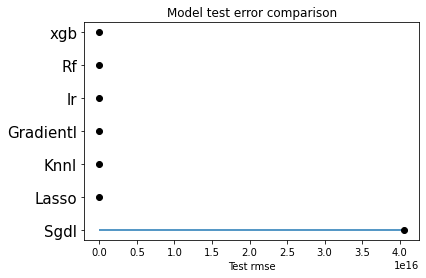

In [61]:
error_modelos = pd.DataFrame({
                        'modelo': ["Lasso", "Sgdl", "Knnl", "Gradientl", "Rf", "lr", "xgb"],
                        'rmse': [rmse_lasso, rmse_sdg, rmse_knn, rmse_gbm,rfreg_rmse,lrreg_rmse,xgbreg_rmse]
                     })
error_modelos = error_modelos.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.rmse)
ax.plot(error_modelos.rmse, error_modelos.modelo, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_title('Model test error comparison'),
ax.set_xlabel('Test rmse');
plt.savefig("Comparation.jpg", dpi = 100)